## Setting up the enviromnent

In this section, we're setting up our Python environment for data analysis and machine learning. We import various libraries, such as NumPy, pandas, Matplotlib, Seaborn, scikit-learn, and others. These libraries are fundamental to our data manipulation, visualization, and machine learning tasks.

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier


## Loading data

Here, we load our dataset from an online source (a CSV file) using the `pd.read_csv` function. We then split the data into features (X) and the target variable (y).


In [3]:
data = pd.read_csv('https://raw.githubusercontent.com/ielbadisy/HDS_courses/master/datasets/heart_arthritis2.csv')
X = data.drop(['heart.attack'], axis=1)
y = data['heart.attack']


## Splitting data

In this step, we split our dataset into training and testing sets using `train_test_split` from scikit-learn. This is a crucial step for evaluating the performance of our machine learning models.

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Partie 1: Logistic regression

## Train and test the model

In this section, we focus on logistic regression. We begin by standardizing our features using StandardScaler to ensure that they have similar scales.

After preprocessing, we train a logistic regression model on our training data and evaluate its performance on our testing data.

## Feature Scaling and Checking for Multicollinearity

We then calculate Variance Inflation Factors (VIF) to check for multicollinearity among our features.


In [5]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert scaled data back to DataFrame
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X.columns)

# Add constant to the scaled DataFrame
X_train_const = sm.add_constant(X_train_scaled_df)

# Now compute VIFs
vif_data = pd.DataFrame()
vif_data["Variable"] = X_train_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_train_const.values, i) for i in range(X_train_const.shape[1])]
print(vif_data)

                 Variable       VIF
0                   const  1.000000
1           arthritis.has  1.279002
2   heart.attack.relative  1.027826
3                  gender  1.114020
4                     age  1.402029
5                     bmi  1.074860
6                diabetes  1.127617
7                 alcohol  1.166985
8                   smoke  1.121056
9         prehypertension  1.016712
10             vegetarian  1.007749
11         covered.health  1.132106


## Train and Test the Model


In [6]:

logistic_model = LogisticRegression(max_iter=10000)
logistic_model.fit(X_train, y_train)
y_pred = logistic_model.predict(X_test)

## Model selection

### Variable importance

In logistic regression, the magnitude (absolute value) of coefficients can be used as an indicator of variable importance. Larger magnitudes signify higher importance.

To visualize variable importance, we use a horizontal bar chart.

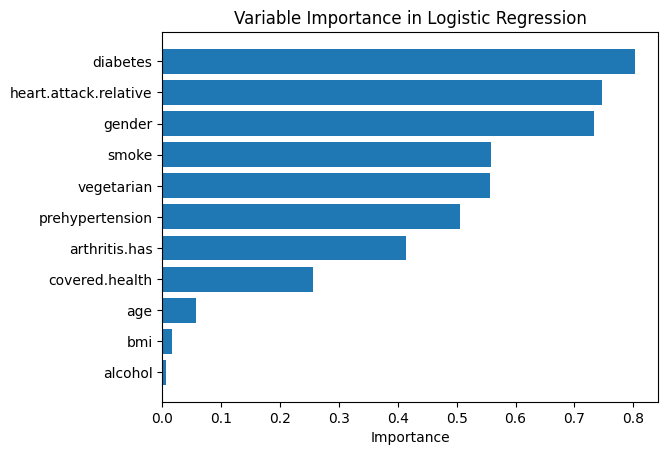

In [7]:
feature_importance = abs(logistic_model.coef_[0])
sorted_idx = np.argsort(feature_importance)
plt.barh(X.columns[sorted_idx], feature_importance[sorted_idx])
plt.xlabel("Importance")
plt.title("Variable Importance in Logistic Regression")
plt.show()


### Multiple hypotheses tests

Here, we employ statsmodels to obtain the significance (p-values) of the logistic regression coefficients. This helps us assess the statistical significance of each feature's impact on the target variable.



In [8]:
X_with_const = sm.add_constant(X_train)
model = sm.Logit(y_train, X_with_const).fit()
print(model.summary())


Optimization terminated successfully.
         Current function value: 0.145366
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:           heart.attack   No. Observations:                 3884
Model:                          Logit   Df Residuals:                     3872
Method:                           MLE   Df Model:                           11
Date:                Wed, 18 Oct 2023   Pseudo R-squ.:                  0.1729
Time:                        04:43:23   Log-Likelihood:                -564.60
converged:                       True   LL-Null:                       -682.63
Covariance Type:            nonrobust   LLR p-value:                 2.310e-44
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -8.0583      0.647    -12.452      0.000      -9.327      -6.

### Compute and Plot ORs
Odds Ratio (OR) is the exponential of the coefficients in logistic regression. It gives the change in odds for a unit change in the predictor.


$OR = e^{\beta}$, where $\beta$ is the regression coefficient associated to each predictor.

In [9]:
# computing OR
print(pd.DataFrame({"var":X_train.columns,"coef":logistic_model.coef_[0], "OR":np.exp(logistic_model.coef_[0])}))




                      var      coef        OR
0           arthritis.has  0.414298  1.513308
1   heart.attack.relative  0.747003  2.110665
2                  gender  0.733802  2.082984
3                     age  0.057180  1.058846
4                     bmi  0.016788  1.016930
5                diabetes  0.802062  2.230136
6                 alcohol  0.006813  1.006836
7                   smoke  0.558493  1.748036
8         prehypertension  0.505036  1.657045
9              vegetarian  0.556522  1.744595
10         covered.health -0.255334  0.774657


# Partie 2: Compare the Logistic Regression to Other Machine Learning Algorithms


Cross-validation provides a better measure of model performance. The most common type is k-fold CV.

$CV = \frac{1}{k} \sum_{i=1}^{k} Accuracy_i$

Where \( k \) is the number of folds.


Now we compare the performance of logistic regression with other machine learning algorithms (Decision Tree and Random Forest) using cross-validation.

We split our data into multiple folds and evaluate each model's mean accuracy and standard deviation of accuracy.

## Basic Cross-Validation for All Models


In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score


# Models
models = [
    ("Logistic Regression", LogisticRegression(max_iter=10000)),
    ("Decision Tree", DecisionTreeClassifier(random_state=42)),
    ("Random Forest", RandomForestClassifier(random_state=42)),
]

for name, model in models:
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    print(f"{name} CV Accuracy: {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores):.4f})")


Logistic Regression CV Accuracy: 0.9578 (+/- 0.0005)
Decision Tree CV Accuracy: 0.9161 (+/- 0.0048)
Random Forest CV Accuracy: 0.9519 (+/- 0.0033)


GridSearchCV helps us find the best hyperparameters for each machine learning algorithm. We search through a predefined grid of hyperparameters to identify the combination that yields the best performance.


First, let's expand our model list and also the hyperparameter tuning grid:


In [34]:
# Parameters for GridSearchCV
param_grids = {
    "Logistic Regression": {"C": [1, 10, 100], "penalty": ["l2"]},
    "Decision Tree": {"max_depth": [None, 5, 10, 15, 20]},
    "Random Forest": {"n_estimators": [50, 100, 150], "max_depth": [None, 5, 10]}
}

# Continuing with the Hyperparameter tuning using GridSearchCV:
best_params = {}
for name, model in models:
    grid_search = GridSearchCV(model, param_grids[name], cv=5)
    grid_search.fit(X_train, y_train)
    best_params[name] = grid_search.best_params_
print(best_params)


{'Logistic Regression': {'C': 1, 'penalty': 'l2'}, 'Decision Tree': {'max_depth': 5}, 'Random Forest': {'max_depth': 5, 'n_estimators': 50}}


## Model Evaluatio  and comparison

We can evaluate our best-tuned models on the test set. We also calculate and plot Receiver Operating Characteristic (ROC) curves and Area Under the Curve (AUC) to assess our models' ability to distinguish between classes.

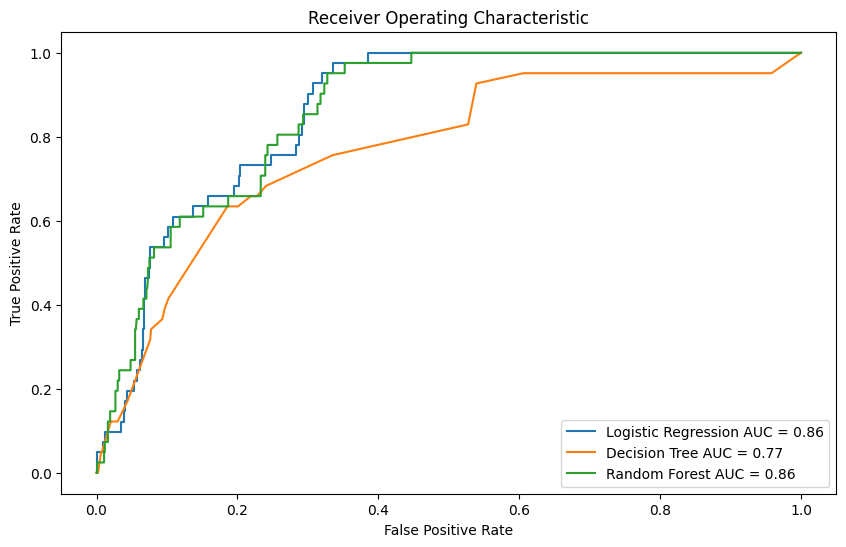

In [38]:
plt.figure(figsize=(10, 6))

for name, model in models:
    model.set_params(**best_params[name])
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # ROC Curve and AUC
    y_prob = model.predict_proba(X_test)[:, 1]  # get probabilities for positive class
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} AUC = {roc_auc:.2f}")

plt.title('Receiver Operating Characteristic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()



## Advanced tip to logistic regression: LASSO

This section introduces the implementation of LASSO (Least Absolute Shrinkage and Selection Operator) regularization for logistic regression. We explore how LASSO can be used to select a subset of important features by setting some coefficients to zero.


In [32]:
lasso_model = LogisticRegression(penalty="l2", solver="liblinear", max_iter=10000)
lasso_model.fit(X_train_scaled, y_train)
selected_features = np.where(lasso_model.coef_[0] > 0.2)[0]
print("Selected features using Lasso:", X.columns[selected_features])

Selected features using Lasso: Index(['heart.attack.relative', 'gender', 'age', 'diabetes', 'smoke'], dtype='object')
